# What is Handwritten Digit Recognition?
Handwritten digit recognition is the ability of computers to recognize human handwritten digits. It is a hard task for the machine because handwritten digits are not perfect and can vary from person to person. Handwritten digit recognition is the solution to this problem which uses the image of a digit and recognizes the digit present in the image.

# About the Dataset

This dataset is inspired by the MNIST database for handwritten digits. It consists of images representing digits from 0-9 produced using 2,990 google fonts files.

The dataset consists of a single file:

TMNIST_Data.csv

This file consists of 29,900 examples with labels and font names. Each row contains 786 elements: the first element represents the font name (ex-Chivo-Italic, Sen-Bold), the second element represents the label (a number from 0-9) and the remaining 784 elements represent the grayscale pixel values (from 0-255) for the 28x28 pixel image.



# What is Convolutional Neural Network

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm that can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

A ConvNet's architecture is influenced by how the Visual Cortex is organised and is similar to the connectivity network of neurons in the human brain. While there are many complex CNN architectures like Resnet, Inception V3 and so on designed to achieve state-of-the-art performance on real world images, in this tutorial, we will create a custom Convolutional Neural Network Architecture using Pytorch.

We will be training and testing our model on the Typeface MNIST Dataset, which consists of over 29,000 samples of images of 0-9 digits in various fonts along with their labels.

<img src= "https://upload.wikimedia.org/wikipedia/commons/b/b6/Artificial_neural_network.png" alt ="Titanic" style='width: 700px;'>

This notebook is further divided into the following sections.

- Importing required Libraries
- Loading the dataset
- Creating a CNN Model
- Training our model
- Evaluating our model

# Importing All necessary librarirs

In [1]:

#import pytorch
import torch

# torch functionalities used for building our CNN Model
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as data_utils

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# How to train your neural net faster?
We saw that the computationally intensive part of neural network is made up of multiple matrix multiplications. So how can we make it faster?

Since we will be building a CNN model, a GPU is required to speed up the training process. Before starting with the implementation, we verify the presence of an active GPU and set the device accordingly.

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:

#Reading data into pandas dataframe.
#data_path = "/kaggle/input/94-character-tmnist/94_character_TMNIST.csv"
data_path = "/kaggle/input/tmnist-typeface-mnist/TMNIST_Data.csv"
data = pd.read_csv(data_path)


# Performing EDA

In [5]:
#A view of dataset.
data.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Determining Shape and Number of Sample in the Dataset
print(f"The Shape of the Dataframe is: {data.shape}") #Number of Samples, Number of Pixels(Features)
print(f"Number of Samples: {data.shape[0]}")

The Shape of the Dataframe is: (29900, 786)
Number of Samples: 29900


In [7]:
# Number of unique character in the Dataframe
print(f"Number of unique character present in the Dataset: {len(data.labels.unique())}") #Number of Classes


Number of unique character present in the Dataset: 10


In [8]:
# Label distribution
data.labels.value_counts()

2    2990
8    2990
4    2990
3    2990
1    2990
6    2990
5    2990
9    2990
7    2990
0    2990
Name: labels, dtype: int64

We observe that the labels are equally distributed with 2990 instances of each class. Hence, our dataset is balanced.

Now, let us reshape and modify our data so that it can be used as an input for our model. We normalise the data and reshape it into a 4 dimensional array such that it represents images stacked on to each other. We also reshape our labels into a 1 dimensional array.

In [9]:
#Dropping redundant coloums like names and labels from the training frames and keeping only pixel values
X = data.drop(columns = {'names', 'labels'})/255
X = X.values.reshape(X.shape[0], 1, 28, 28)
y = data[['labels']].values.reshape((-1,))

Before proceeding, we split our data into training and testing sets using an 80:20 proportion.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

We now convert them to numpy arrays so that they can be further worked with.

In [11]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

Before proceeding, we split our data into training and testing sets using an 80:20 proportion.

In [12]:
print(X_train.shape, y_train.shape)

torch.Size([23920, 1, 28, 28]) torch.Size([23920])


We verify our steps by checking the shape of our newly created torch tensors.

Now, let us visualise a sample image from our processed data.

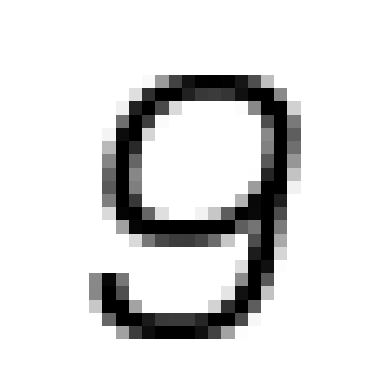

In [13]:
def visualize_image(data):
    plt.imshow(data[0], cmap='gray_r')
    plt.axis("off")
    plt.show()

visualize_image(X_train[0])

#  Create a CNN Model
Create Data Loader
Dataloaders are utilized to feed our input data to our model for training, based on different parameters such as the batch size, if they should be suffled while being fed, and so on.

Here, we define our tensordatasets for the dataloader and then input our required parameters to prepare the data loaders.

In [14]:
print(type(X_train))
print(type(y_train))


<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [15]:
train = data_utils.TensorDataset(X_train,y_train)
test = data_utils.TensorDataset(X_test,y_test)

Once you have created your TensorDataset objects, you can pass them to data loaders in PyTorch to efficiently load and preprocess your data during model training or testing. Data loaders allow you to iterate over your dataset in batches, shuffle the data, and apply other data augmentation techniques as needed

In [16]:
train_loader = data_utils.DataLoader(train, batch_size = 128, shuffle = True)
test_loader = data_utils.DataLoader(test, batch_size = 128, shuffle = True)

To verify our data loaders, we print the input size of an iteration of training.

In [17]:
#printing input size of an iteration of training
for images, labels in train_loader:
    print(images.shape, labels.shape)

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape, labels.shape)



torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([1

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Create Model

- Convolution layer (CONV)- The convolution layer (CONV) uses filters that perform convolution operations as it is scanning the input I with respect to its dimensions. Its hyperparameters include the filter size F and stride S. The resulting output O is called feature map or activation map.
- Pooling (POOL)- The pooling layer (POOL) is a downsampling operation, typically applied after a convolution layer, which does some spatial invariance. In particular, max and average pooling are special kinds of pooling where the maximum and average value is taken, respectively.

To create our CNN Model, we utilise the neural network module from pytorch and provide it with our own custom architecture as follows.

- Convolutional layer with 32 channels
- Convolutional layer with 64 channels
- MaxPooling layer to compress information
- Dense layer to flatten the information obtained
- Dense output layer with relu activation

We use Cross Entropy Loss as the loss function and Adam as the optimizer here. You can also try out other optimizers like SGD here 

In [19]:

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.001)

Finally, inorder to deal with input data in the float format, we modify the format of our CNN model net to float.

In [20]:
net = net.float()

# Train Model

Definitions:

- Epoch- In the context of training a model, epoch is a term used to refer to one iteration where the  model sees the whole training set to update its weights.


- Mini batch gradient descent- During the training phase, updating weights is usually not based on the  whole training set at once due to computation complexities or one data point due to noise issues. Instead, the update step is done on mini-batches, where the number of data points in a batch is a hyperparameter that we can tune.


- Loss function -In order to quantify how a given model performs, the loss function .L is usually used   to evaluate to what extent the actual outputs y are correctly predicted by the model outputs z.


- Cross-entropy lossIn the context of binary classification in neural networks, the cross-entropy loss 
 L(z,y) is commonly used and is defined as follows:


We now train the model for 15 epochs and print its loss and test accuracy for each 50 completed mini batches. I used 15 epochs as it provided a satisfactory learning curve for this dataset, but feel free to explore with other number as well.

In [21]:
epoch_num = 0
actual_loss = 0.0
accuracy = 0.0

In [22]:
#training model with 15 epochs
num_epochs = 15

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(num_epochs):
    print(f'Starting Epoch: {epoch + 1}...')

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs.float())
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 49:
            correct = 0
            total = 0
            
            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = net(images.float())
                    
                    _, predicted = torch.max(outputs.data, dim = 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                
                accuracy = 100 * correct / total
                actual_loss = running_loss / 50
                epoch_num = epoch + 1
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i + 1)}, Loss: {actual_loss:.3f}, Test Accuracy: {accuracy:.3f}%')
                
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Training Completed.')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 0.614, Test Accuracy: 94.047%
Epoch: 1, Mini-Batches Completed: 100, Loss: 0.776, Test Accuracy: 96.656%
Epoch: 1, Mini-Batches Completed: 150, Loss: 0.902, Test Accuracy: 97.258%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.083, Test Accuracy: 97.809%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.150, Test Accuracy: 97.993%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.206, Test Accuracy: 98.395%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Completed: 50, Loss: 0.041, Test Accuracy: 98.796%
Epoch: 3, Mini-Batches Completed: 100, Loss: 0.086, Test Accuracy: 98.796%
Epoch: 3, Mini-Batches Completed: 150, Loss: 0.120, Test Accuracy: 98.829%
Starting Epoch: 4...
Epoch: 4, Mini-Batches Completed: 50, Loss: 0.027, Test Accuracy: 98.896%
Epoch: 4, Mini-Batches Completed: 100, Loss: 0.056, Test Accuracy: 99.013%
Epoch: 4, Mini-Batches Completed: 150, Loss: 0.079, Test Accuracy: 98.779%
Starting Epoch: 5...

# Saving Model
Let's save our trained model to PATH so that it can be reused.

In [23]:
PATH = './cnn_net.pth'
torch.save(net.state_dict(), PATH)

# Evaluating  Model
Reloading Model
To evaluate our trained CNN model, we reload our saved model.

In [24]:
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# How well our model makes prediction with test data?
Now, let us use our test dataset to determine the final accuracy of our trained model.

In [25]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        label_size = labels.size(0)
        total += label_size
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on test images: {accuracy:.3}%')

Accuracy of the network on test images: 99.2%


As we observe, our model achieves an accuracy of 99.2% on the test images.

# Classification Observations
Let us also view some of the classifications our model performs on the test data.

Actual Label: 6, Predicted Label: 6


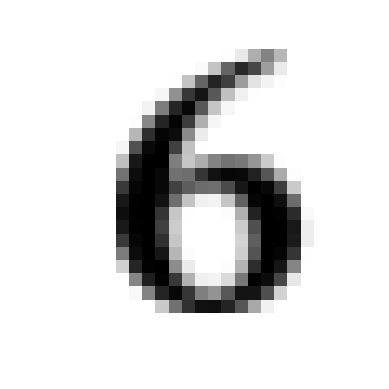

Actual Label: 0, Predicted Label: 0


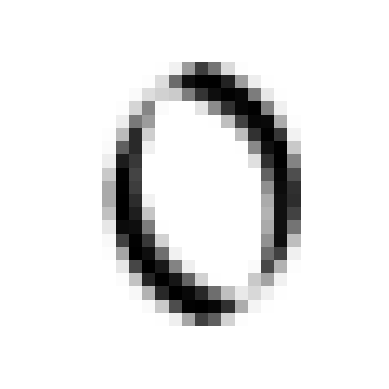

Actual Label: 2, Predicted Label: 2


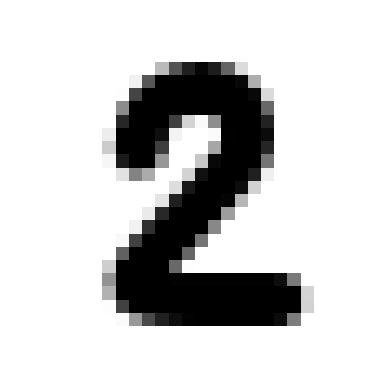

Actual Label: 0, Predicted Label: 0


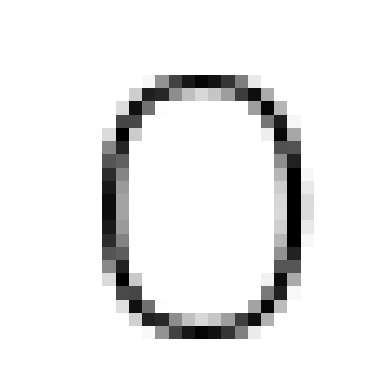

Actual Label: 4, Predicted Label: 4


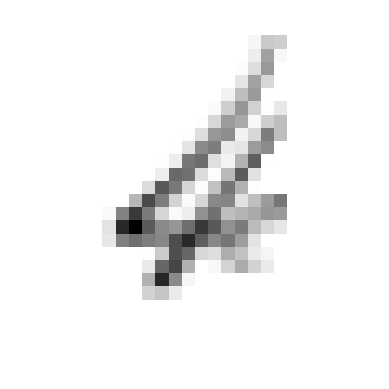

In [26]:
net.eval()
num_images = 5

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images.float())
        predictions = torch.argmax(outputs, dim=1)

        for i in range(data[0].shape[0]):
            pred = predictions[i].item()
            label = labels[i]
            if(num_images > 0):
                print(f'Actual Label: {pred}, Predicted Label: {label}')       
                img = np.reshape(images[i].cpu().numpy(),[1,28,28])
                visualize_image(img)
                num_images -= 1

# Plotting training logs
To further understand and analyse the training of our model, let us plot the training logs for loss and accuracy.

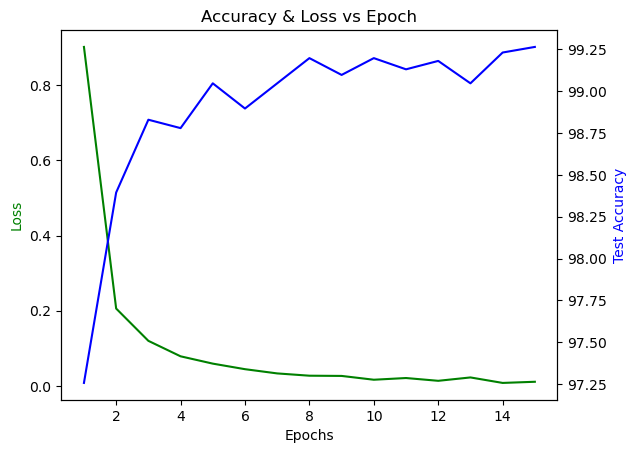

In [27]:
fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch")
ax2 = ax1.twinx()

ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

Observations: As the Number of Epochs increases i.e number of times you run the dataset through model, test accuracy increases and loss decreases

# Plotting Confusion Matrix
Lastly, let us plot the confusion matrix to evaluate the classwise performance of our model and understand where it can do better.

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [29]:
pred_list = torch.zeros(0, dtype=torch.long, device='cpu')
label_list = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs.float())
        _, preds = torch.max(outputs, 1)

        pred_list = torch.cat([pred_list, preds.view(-1).cpu()])
        label_list = torch.cat([label_list, classes.view(-1).cpu()])

In [30]:
# print(classification_report(label_list.numpy(), pred_list.numpy()))


As we observe, the highest F1-Score is reported by the label 4 while the lowest is of label 1. This is due to label 1 having the lowest precision of 0.94. This can be improved by adding more data, using data augmentation techniques, checking for mislabelling and so on.

Further, let us visualise this confusion matrix.

In [31]:
conf_mat = confusion_matrix(label_list.numpy(), pred_list.numpy())
class_names = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
dataframe = pd.DataFrame(conf_mat, index=class_names, columns=class_names)

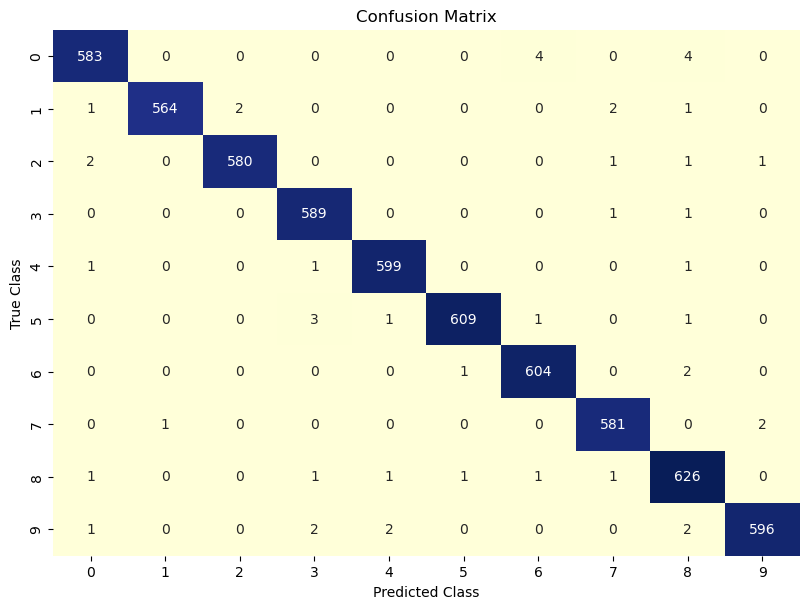

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

Observations:

He we infer that , 558 times the label was 0 and our model predicted it as 0.Similarly 567 times label was 1 and and model predicted 1. Highest value is 4 , which means four times the label was 8 (True class) and our model predicted it 3, which is considered as error. 

# Conclusion

- The accuracy on test test is 99.2% which is really good for CNN
- Now we have successfully created a  CNN model using Pytorch.

# References
- https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
- https://www.youtube.com/watch?v=iqQgED9vV7k
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel